In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from skimage.filters import sobel, sobel_v, sobel_h
import xarray as xr
from skimage.transform import warp_polar
import h5py
from matplotlib.colors import LogNorm
import pathlib
import datetime
import os
import shutil

In [13]:
sys.path.append('/nsls2/users/alevin/repos/mcmorph')
from growth.crystal import crystalgrowth
cg = crystalgrowth()

In [3]:
from fiberanalysis import *

In [4]:
def orient_plot(array,dpi=140):
    plt.figure(dpi=dpi)
    plt.imshow(array,cmap='hsv',origin='lower',interpolation='none')
    plt.colorbar()
    plt.show()

In [6]:
### Define paths:
rootPath = pathlib.Path('/nsls2/users/alevin/rsoxs_suite')
simsPath = rootPath.joinpath('imgs_analysis/sim_runs')



def list_files(filter_string, path):
    return sorted([f.name for f in path.glob(filter_string)])

def get_file_path(filter_string, path):
    return list(path.glob(filter_string))[0]


a = 0.7
eps = 1.0
shape = '250pix'

simPath = simsPath.joinpath(list_files(f'*a{a}*eps{eps}*{shape}*', simsPath)[0])
list_files('*', simPath)

steps = 600
volume_fraction = np.loadtxt(get_file_path(f'*_{steps}steps*.txt', simPath))

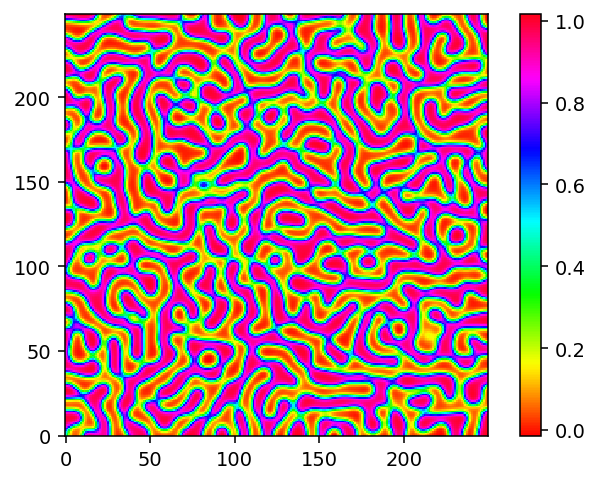

In [9]:
orient_plot(volume_fraction)

In [7]:
# def readcorrect(file,channel='Phase'):
#     ''' Reads phase data from Bruker AFM scan file
#     and aligns rows by subtracting median from each row
#     '''
#     scan = pySPM.Bruker(file)
#     phase = np.array(scan.get_channel(channel).pixels)
#     for i,row in enumerate(phase):
#         phase[i] -= np.median(row)
#     return phase

In [15]:
def full_reduce(img, threshold_val=None):
    if not threshold_val:
        threshold_val = threshold_otsu(img)
    binary_img = img < threshold_val
    binary_img = binary_closing(binary_img,footprint=square(2))
    skeleton_img = skeletonize(binary_img)
    skeleton_img = remove_branches(skeleton_img)
    labeled_img = label(skeleton_img,connectivity=2)
    smoothed_img = create_smooththeta(labeled_img)
    smoothed_img += np.pi/2
    smoothed_img[smoothed_img>np.pi/2] %= -np.pi/2
    smoothed_filled = cg.grow_complete(smoothed_img,growth_anisotropy=2,pi_mutate=np.deg2rad(2),c_mutate=np.deg2rad(2),return_all=False)
#     try:
#     smoothed_filled[binary_img] = np.nan
    smoothed_filled -= np.pi/2
    smoothed_filled[smoothed_filled < -np.pi/2] %= np.pi/2

    return smoothed_filled, binary_img
#     except IndexError:
#         return smoothed_filled

def full_reduce2(img, threshold_val=None):
    if not threshold_val:
        threshold_val = threshold_otsu(img)
    binary_img = img > threshold_val
    binary_img = binary_closing(binary_img,footprint=square(2))
    skeleton_img = skeletonize(binary_img)
    skeleton_img = remove_branches(skeleton_img)
    labeled_img = label(skeleton_img,connectivity=2)
    smoothed_img = create_smooththeta(labeled_img)
    smoothed_img += np.pi/2
    smoothed_img[smoothed_img>np.pi/2] %= -np.pi/2
    smoothed_filled = cg.grow_complete(smoothed_img,growth_anisotropy=2,pi_mutate=np.deg2rad(2),c_mutate=np.deg2rad(2),return_all=False)
#     try:
#     smoothed_filled[binary_img] = np.nan
    smoothed_filled -= np.pi/2
    smoothed_filled[smoothed_filled < -np.pi/2] %= np.pi/2

    return smoothed_filled, binary_img

In [17]:
smoothed_filled, binary_img = full_reduce(volume_fraction, threshold_val=0.5)

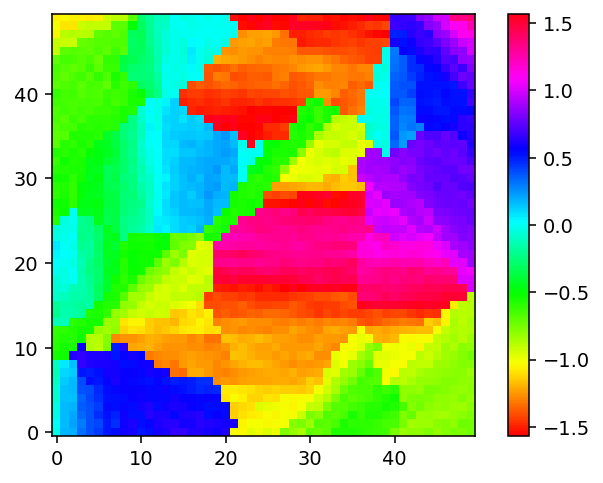

In [20]:
orient_plot(smoothed_filled[0:50,0:50])

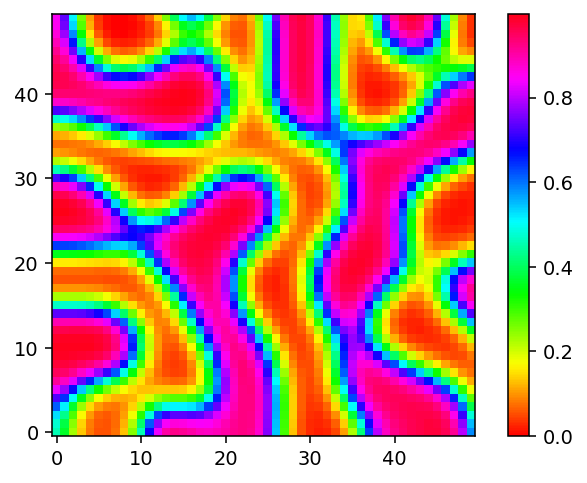

In [21]:
orient_plot(volume_fraction[0:50,0:50])

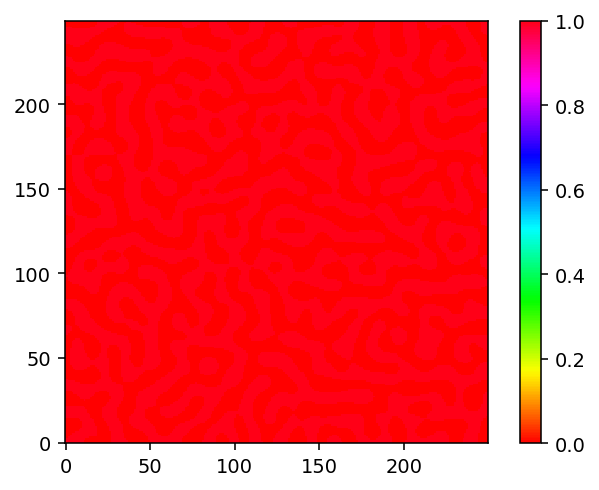

In [19]:
orient_plot(binary_img)